In [1]:
import pandas as pd
import numpy as np
import wrangle, scale, explore, cluster
import warnings
warnings.filterwarnings("ignore")

## Wrangle 

In [2]:
zillow = wrangle.get_all_zillow_data()
zillow = zillow.sort_values('transactiondate').drop_duplicates('parcelid',keep='last')

In [3]:
zillow.shape

(77381, 69)

In [4]:
col, row = wrangle.get_nulls(zillow)

<class 'pandas.core.series.Series'>


In [5]:
#drop any col missing 60% of its data
zillow = wrangle.drop_null_columns(zillow,60)

<class 'pandas.core.series.Series'>


In [6]:
#drop any row missing 50% of its data
zillow = wrangle.drop_null_rows(zillow, 50)

In [7]:
#drop remaining data
zillow = zillow.dropna()

In [8]:
zillow.isna().sum().sum()

0

### Feature Engineering 

In [9]:
zillow = wrangle.zillow_engineering(zillow)

In [10]:
#filter by single unit housing
zillow = zillow[(zillow.propertylandusedesc == 'Single Family Residential') |
          (zillow.propertylandusedesc == 'Mobile Home') |
          (zillow.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
          (zillow.propertylandusedesc == 'Townhouse')]
zillow.shape

(32047, 37)

In [11]:
zillow.columns

Index(['propertylandusetypeid', 'heatingorsystemtypeid', 'parcelid', 'id',
       'logerror', 'transactiondate', 'id.1', 'bathroomcnt', 'bedroomcnt',
       'buildingqualitytypeid', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock',
       'heatingorsystemdesc', 'propertylandusedesc', 'taxrate',
       'transactionmonth'],
      dtype='object')

## Split/Scale

In [12]:
train , validate, test = wrangle.split_for_model(zillow)
train_scaled, validate_scaled, test_scaled = scale.scale_data(train, validate, test, 'Robust',\
                                                              to_scale=['calculatedfinishedsquarefeet','latitude','longitude',\
                                                                        'lotsizesquarefeet', 'yearbuilt','structuretaxvaluedollarcnt',\
                                                                        'taxvaluedollarcnt', 'taxamount', 'landtaxvaluedollarcnt','taxrate'])

train(17945, 37),validate(7692, 37),test(6410, 37)


## Explore

### Exploring Variables in relation to Target = Log Error

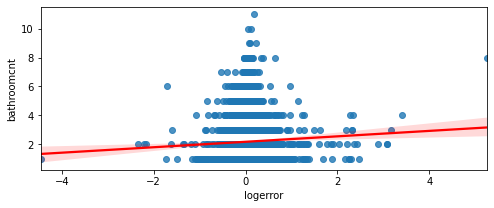

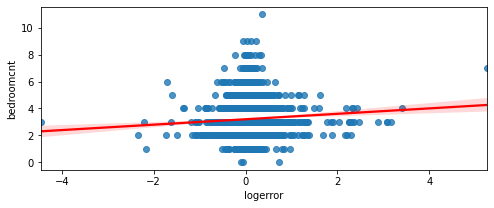

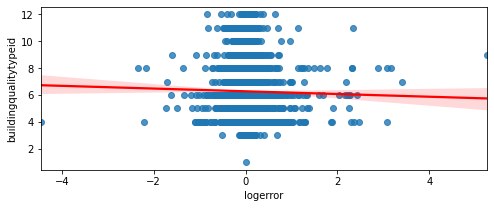

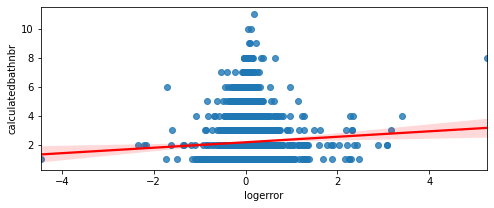

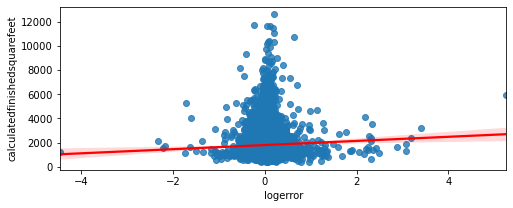

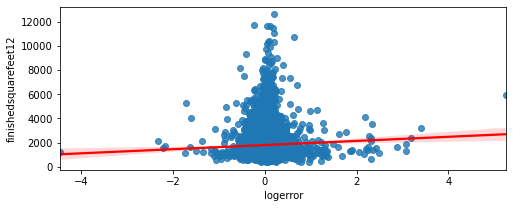

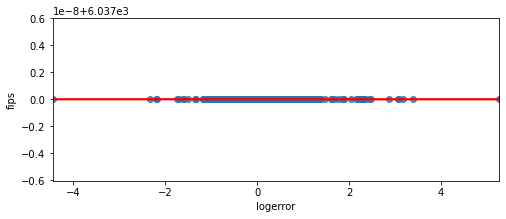

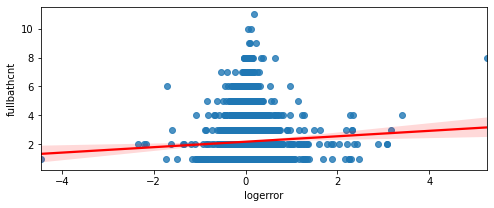

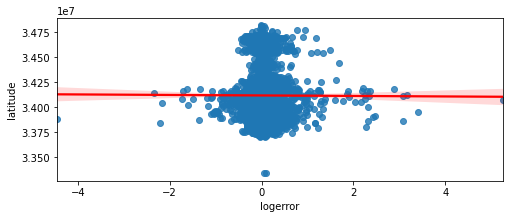

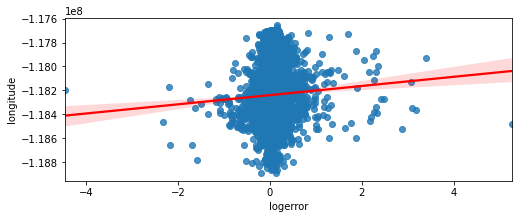

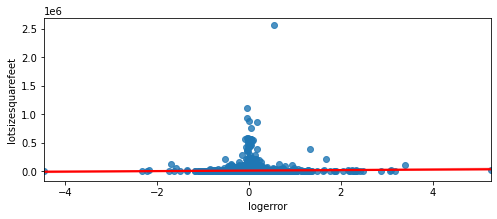

TypeError: can't multiply sequence by non-int of type 'float'

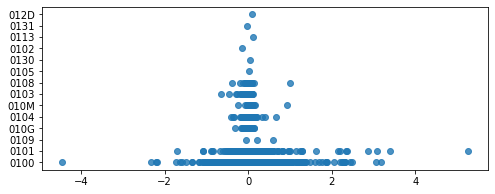

In [15]:
explore.plot_variable_pairs(train.drop(columns=['propertylandusetypeid','heatingorsystemtypeid', 'parcelid', 'id','id.1','transactiondate']))